# Geospatial API Project
Silver Sloths - Habeeb Branch<br>
October 2, 2021<br>

Goal of this project is to:
1. Read in and merge datasets containing aggravated burglary attempts, population, and median income information for each census tract in Davidson County, TN.
2. Graph a choropleth of Davidson County showing the number of aggravted burglary attempts per 1000 residents in each Census tract.
3. Determine which General Linear Model, between Poisson regression and Negative Binomial Regression, best fits the dataset. 

In [1]:
import requests
import matplotlib.pyplot as plt
from IPython.display import Image
import pandas as pd
import json
from io import StringIO
from shapely.geometry import Point
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
import re
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import numpy as np
from patsy import dmatrices
import warnings

# Ignore warnings throughout the code
warnings.filterwarnings("ignore")

In [2]:
# Read in all aggravated burglary data between January 1, 2021 and June 30, 2021
burglary_endpoint =  "https://data.nashville.gov/resource/2u6v-ujjs.geojson"
params = {
    "$where": "incident_reported between '2021-01-01T00:00:00' and '2021-06-30T23:59:59'",
    'offense_description': 'BURGLARY- AGGRAVATED',
    '$limit': '100000'
}
burglary_response = requests.get(burglary_endpoint,  
                                 params = params)
burglary = gpd.read_file(StringIO(burglary_response.text))

In [3]:
# Drop duplicate incidents
burglary = burglary.drop_duplicates(subset='incident_number')

# Read in census tract shape files
tn_shape = gpd.read_file('../data/tl_2019_47_tract.shp')
burglary.crs = tn_shape.crs

# Spatial Join between Burglary and Census Tract Shape Data
tn_burglary = gpd.sjoin(tn_shape, 
                        burglary,
                        how = 'inner',
                        op = 'contains')

In [4]:
# Rename columns and drop unneeded columns
tn_burglary = (tn_burglary.rename({'NAMELSAD':'TRACT_NAME',
                                   'TRACTCE': 'TRACT'},
                                    axis='columns'))

# Count up the amount of assaulted burglaries in each census tract
tn_burglary['TRACT_NAME'].value_counts()

Census Tract 163       53
Census Tract 162       21
Census Tract 110.01    20
Census Tract 193       19
Census Tract 195       19
                       ..
Census Tract 178        1
Census Tract 188.01     1
Census Tract 119        1
Census Tract 186.01     1
Census Tract 182.02     1
Name: TRACT_NAME, Length: 148, dtype: int64

Census tract 163 has the most aggravated burglary cases between Janury 1, 2021 and June 30, 2021 at 53 cases.

In [5]:
# Read in API key for census site
with open('../data/census.json') as fi:
    credentials = json.load(fi)
    
api_key = credentials['api_key']

# Read in population data from Census website
population_endpoint = "https://api.census.gov/data/2019/acs/acs5?get=NAME,B01001_001E&for=tract:*&in=state:47&in=county:037&key={}".format(api_key)
population_response = requests.get(population_endpoint)
population = pd.read_csv(StringIO(population_response.text))

# Read in median income data from Census website
median_income_endpoint = "https://api.census.gov/data/2019/acs/acs5/subject?get=NAME,S1901_C01_012E&for=tract:*&in=state:47&in=county:037&key={}".format(api_key)
median_income_response = requests.get(median_income_endpoint)
median_income = pd.read_csv(StringIO(median_income_response.text))

In [6]:
# Extract and clean info from population index
census_tract = []
for length in range(len(population.index)):
    global census_tract
    census_tract.append(re.sub(r"\W{2}","",population.index[length][0]))
    
# Create a new column with cleaned data from above
population["TRACT_NAME"] = census_tract

# Reset index of dataframe
population.index = range(len(population.index))

In [7]:
# Create a new column with cleaned data from above
median_income["TRACT_NAME"] = census_tract

# Reset index of dataframe
median_income.index = range(len(median_income.index))

In [8]:
# Rename and drop columns in population
population = (population.drop(columns=['[["NAME"','state','county','Unnamed: 5', 'tract]'])
                 .rename({'B01001_001E':'population'},
                         axis='columns'))

# Rename and drop columns in median_income
median_income = (median_income.drop(columns=['[["NAME"','state','county','Unnamed: 5', 'tract]'])
                 .rename({'S1901_C01_012E':'median_income'},
                         axis='columns'))

In [9]:
# Merge retrieved population and median income data with the burglary data from earlier
tn = pd.merge(tn_burglary, population, on="TRACT_NAME")
tn = pd.merge(tn, median_income, on="TRACT_NAME")

In [10]:
# Examine population and median income data
print(tn[tn['population'] <= 0])
print('-----------------------------')
print(tn[tn['median_income'] <= 0])

    STATEFP COUNTYFP   TRACT        GEOID  NAME         TRACT_NAME  MTFCC  \
573      47      037  980100  47037980100  9801  Census Tract 9801  G5020   
574      47      037  980100  47037980100  9801  Census Tract 9801  G5020   
575      47      037  980100  47037980100  9801  Census Tract 9801  G5020   

    FUNCSTAT     ALAND  AWATER  ... report_type_description victim_type  \
573        S  15585506  204571  ...              DISPATCHED           I   
574        S  15585506  204571  ...              DISPATCHED           I   
575        S  15585506  204571  ...              DISPATCHED           I   

    incident_status_code  incident_status_description  zone victim_gender  \
573                    O                         OPEN  None             M   
574                    O                         OPEN  None             F   
575                    O                         OPEN  None             F   

       incident_occurred     primary_key population median_income  
573  2021-04-

Upon reviewing the data, I found that four of the rows have negative median income.<br>
To prevent errors with the data visualizations later on, I will delete these rows before moving on.

In [11]:
# Drop rows with non-positive population and median incomes
tn = tn.drop(index=[33,573,574,575])

In [12]:
# Determine total count per census tract
count = tn['TRACT_NAME'].value_counts().to_dict()
burglary_count = tn['TRACT_NAME'].map(count) 
tn['burglary_count'] = burglary_count

# Create column with burglaries per 1000 residents
tn['burglaries_per_1000'] = tn['burglary_count'] / (tn["population"] / 1000)

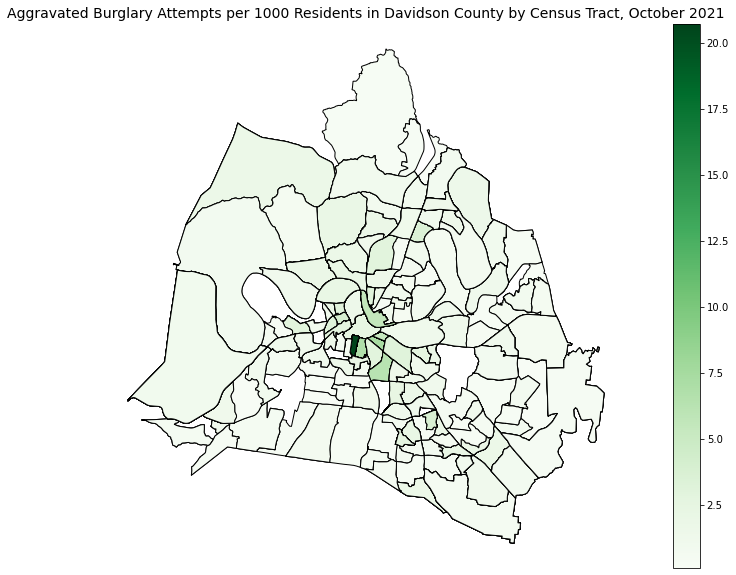

In [13]:
# Create choropleth for burglary attempts per 1000 residents
fig, ax = plt.subplots(figsize=(16,10))
tn.plot(column = 'burglaries_per_1000',
        cmap = 'Greens',
        edgecolor = 'black',
        legend = True,
        ax = ax)

plt.title('Aggravated Burglary Attempts per 1000 Residents in Davidson County by Census Tract, October 2021', fontsize = 14)
ax.axis('off');

In the above graph we can see that the Edgehill area (census tract 163) has the most aggravated burglary attempts per 1000 residents in Davidson County.

In [14]:
# Create condensed dataframe for regression models
tn_condensed = tn.drop_duplicates(subset='TRACT_NAME')

In [15]:
# Build a base Poisson regression model with target variable equal to burglaries per census tract and offset by population
posreg_burglaries = (sm.GLM(endog = tn_condensed['burglary_count'],
                            offset = np.log(tn_condensed['population'] / 1000),
                            exog = sm.add_constant(tn_condensed[[]]),
                            family = sm.families.Poisson())
                     .fit())

print(posreg_burglaries.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         burglary_count   No. Observations:                  146
Model:                            GLM   Df Residuals:                      145
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -562.07
Date:                Mon, 11 Oct 2021   Deviance:                       642.01
Time:                        18:49:50   Pearson chi2:                 1.30e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2354      0.035      6.749      0.0

In [16]:
# Build a Poisson regression model with target variable = burglaries per census tract, predictor variable = median income 
# and offset by population
posreg_burglaries_median = (sm.GLM(endog = tn_condensed['burglary_count'],
                                   offset = np.log(tn_condensed['population'] / 1000),
                                   exog = sm.add_constant(tn_condensed[['median_income']]),
                                   family = sm.families.Poisson())
                            .fit())

print(posreg_burglaries_median.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         burglary_count   No. Observations:                  146
Model:                            GLM   Df Residuals:                      144
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -497.86
Date:                Mon, 11 Oct 2021   Deviance:                       513.60
Time:                        18:49:50   Pearson chi2:                 1.01e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.2970      0.101     12.901

In [17]:
## Negative Binomial Model

# Extract lambda value from poisson regression and save to dataframe
tn_condensed['LAMBDA'] = posreg_burglaries_median.mu

# Calculate values of the dependent variable of the OLS regression
tn_condensed['AUX_OLS_DEP'] = tn_condensed.apply(lambda x: ((x['burglary_count'] - x['LAMBDA'])**2 - x['LAMBDA']) / x['LAMBDA'], axis=1)

# Determine alpha value
ols_expr = """AUX_OLS_DEP ~ LAMBDA - 1"""
aux_olsr_results = smf.ols(ols_expr, tn_condensed).fit()

# Train the Negative Binomial model on the burglary dataset
negative_binomial = (sm.GLM(endog = tn_condensed['burglary_count'],
                                   offset = np.log(tn_condensed['population'] / 1000),
                                   exog = sm.add_constant(tn_condensed[['median_income']]),
                                   family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0]))
                            .fit())
print(negative_binomial.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:         burglary_count   No. Observations:                  146
Model:                            GLM   Df Residuals:                      144
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -397.98
Date:                Mon, 11 Oct 2021   Deviance:                       109.41
Time:                        18:49:50   Pearson chi2:                     251.
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.2035      0.197      6.104

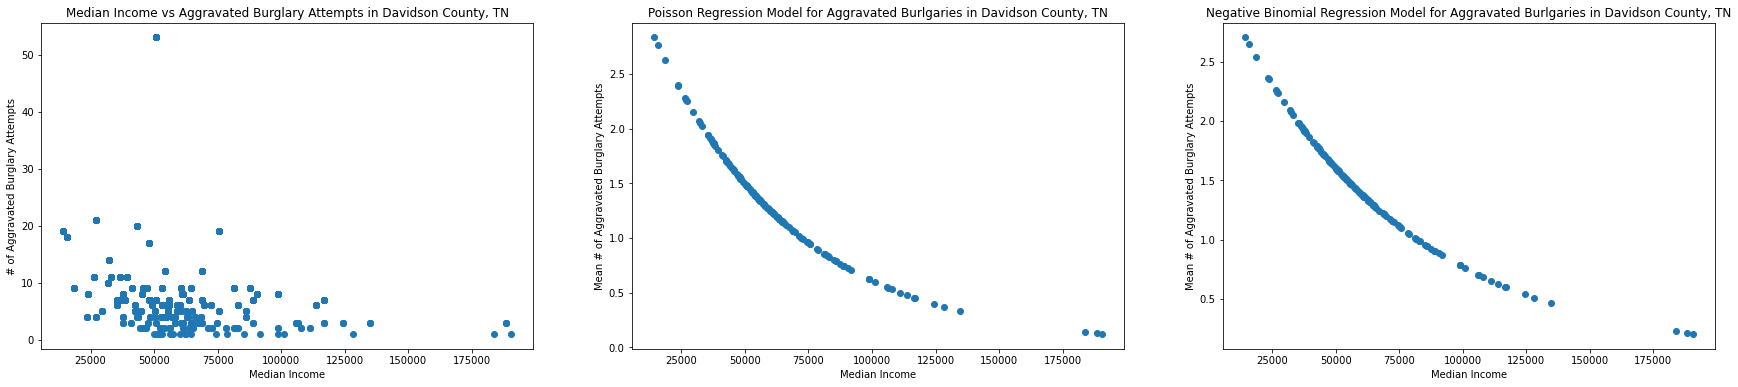

In [18]:
# Plot Median Income vs Total Burglary Attempts
f, axs = plt.subplots(1,2,figsize=(30,6))
plt.subplot(1, 3, 1)
plt.scatter(tn['median_income'], tn['burglary_count']);
plt.title("Median Income vs Aggravated Burglary Attempts in Davidson County, TN")
plt.xlabel("Median Income")
plt.ylabel("# of Aggravated Burglary Attempts");

# Plot Poisson regression results from previous cell
plt.subplot(1, 3, 2)
x = tn_condensed['median_income']
y_poisson = np.exp(1.2970 - (.00001791*x))
plt.scatter(x, y_poisson)
plt.title("Poisson Regression Model for Aggravated Burlgaries in Davidson County, TN")
plt.xlabel("Median Income")
plt.ylabel("Mean # of Aggravated Burglary Attempts");

# Plot Negative Binomial regression results from previous cell
plt.subplot(1, 3, 3)
x = tn_condensed['median_income']
y_neg_binomial = np.exp(1.2035 - (.00001466*x))
plt.scatter(x, y_neg_binomial)
plt.title("Negative Binomial Regression Model for Aggravated Burlgaries in Davidson County, TN")
plt.xlabel("Median Income")
plt.ylabel("Mean # of Aggravated Burglary Attempts");

In [19]:
# Compare AIC Values Between Poisson and Negative Binomial Regression Models
print("AIC for Base Poisson Regression is " + str(posreg_burglaries.aic))
print("AIC for Poisson Regression is " + str(posreg_burglaries_median.aic))
print("AIC for Negative Binomial Regression is " + str(negative_binomial.aic))

AIC for Base Poisson Regression is 1126.1432800453035
AIC for Poisson Regression is 999.7257788156867
AIC for Negative Binomial Regression is 799.9602016431024


## Conclusion
Both the Poisson and Negative Binomial regression models show that the higher the median income for a census tract the fewer aggravated burglaries occur there.<br>
After reviewing the AIC for each model, we see that the best fit model for this dataset is the negative binomial regression model (since the AIC is lower for it).